![data-x](https://raw.githubusercontent.com/afo/data-x-plaksha/master/imgsource/dx_logo.png)

# Convolutional Neural Networks (CNNs) Part - 2

#### Authors: Alexander Fred Ojala, Rajarathnam Balakrishnan

**Sources:** Francois Chollet, Aurélien Géron, etc.
____

# Overview

#### 1. Baseline Cats vs Dogs Image Classifier (~70% Accuracy)

##### |___ 1.1. Data

##### |___ 1.2. Model

##### |___ 1.3. Training

##### |___ 1.4. Testing

#### 2. Baseline + Data Augmentation (~73% Accuracy)

##### |___ 2.1. Data Augmentation

##### |___ 2.2. Model

##### |___ 2.3. Training

##### |___ 2.4. Testing

#### 3. Transfer Learning (~90% Accuracy)

##### |___ 3.1. Introduction

##### |___ 3.2. Convolutional layers and Filters

##### |___ 3.3. Pooling layers

#### 4. Visualizing CNN Learning

# 1. Baseline Cats vs Dogs Image Classifier

## 1.1. Data

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
# Import relevant packages
from __future__ import absolute_import, division, print_function # make it compatible w Python 2
import os
import h5py # to handle weights
import os, random
import numpy as np
import pandas as pd
import cv2 #conda install open-cv

import matplotlib.pyplot as plt
%matplotlib inline 

from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, ZeroPadding2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image

from IPython.display import Image, display

# fix random seed for reproducibility
np.random.seed(150)

In [3]:
# Look at files, note all cat images and dog images are unique
for path, dirs, files in os.walk('./data'):
    print('FOLDER',path)
    for f in files[:2]:
        print(f)

FOLDER ./data
FOLDER ./data/test
FOLDER ./data/test/catvdog
try039.jpg
try005.jpg
FOLDER ./data/train
FOLDER ./data/train/dogs
dog0113.jpg
dog0675.jpg
FOLDER ./data/train/cats
cat0852.jpg
cat0846.jpg
FOLDER ./data/validation
FOLDER ./data/validation/dogs
dog001275.jpg
dog001261.jpg
FOLDER ./data/validation/cats
cat001138.jpg
cat001104.jpg


In [4]:
print('Number of cat training images:', len(next(os.walk('./data/train/cats'))[2]))
print('Number of dog training images:', len(next(os.walk('./data/train/dogs'))[2]))
print('Number of cat validation images:', len(next(os.walk('./data/validation/cats'))[2]))
print('Number of dog validation images:', len(next(os.walk('./data/validation/dogs'))[2]))
print('Number of uncategorized test images:', len(next(os.walk('./data/test/catvdog'))[2]))

# There should be 1000 train cat images, 1000 train dogs, 
# 400 validation cats, 400 validation dogs, 100 uncategorized

Number of cat training images: 1000
Number of dog training images: 1000
Number of cat validation images: 400
Number of dog validation images: 400
Number of uncategorized test images: 100


In [5]:
# Define variables
TRAIN_DIR = './data/train/'
VAL_DIR = './data/validation/'
TEST_DIR = './data/test/' #mixed cats and dogs

img_width, img_height = 150, 150

n_train_samples = 2000
n_validation_samples = 800
n_epoch = 20
n_test_samples = 100

### Data preprocessing

Data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. Currently, our data is JPEG files, so the steps for getting it into our network are roughly:

1. Read the picture files.
2. Decode the JPEG content to RBG grids of pixels.
3. Convert these into floating point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval.

Keras has utilities to take care of these steps automatically.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        TRAIN_DIR,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). 20 is the number of samples in each batch (the batch size).

In [7]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


## 1.2. Model

The right tool for an image classification job is a convnet, so let's try to train one on our data, as an initial baseline. Very similar to LeNet, as a baseline. Roughly ~75% accuracy. Takes 30mins to train on a CPU.

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [10]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## 1.3. Training

Let's fit our model to the data using the generator. We do it using the `fit_generator method`, the equivalent of fit for data generators like ours. Need to define steps_per_epoch because of generator.

In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 2000//32,
      epochs = 30,
      validation_data = validation_generator,
      validation_steps = 800//32,)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 25 steps
Epoch 1/30
62/62 [==============================] - 21s 332ms/step - loss: 0.6983 - acc: 0.5250 - val_loss: 0.6841 - val_acc: 0.5080
Epoch 2/30
62/62 [==============================] - 15s 239ms/step - loss: 0.6750 - acc: 0.5669 - val_loss: 0.6979 - val_acc: 0.5240
Epoch 3/30
62/62 [==============================] - 15s 241ms/step - loss: 0.6648 - acc: 0.5992 - val_loss: 0.6595 - val_acc: 0.5880
Epoch 4/30
62/62 [==============================] - 15s 245ms/step - loss: 0.6229 - acc: 0.6573 - val_loss: 0.6518 - val_acc: 0.6280
Epoch 5/30
62/62 [==============================] - 15s 242ms/step - loss: 0.6033 - acc: 0.6718 - val_loss: 0.6369 - val_acc: 0.6440
Epoch 6/30
62/62 [==============================] - 15s 244ms/step - loss: 0.5703 - acc: 0.6960 - val_loss: 0.6126 - val_acc: 0.6560
Epoch 7/30
62/62 [================

### Saving the trained model as .h5 file

In [12]:
model.save('cats_and_dogs_small_1.h5')

### Loading a saved .h5 model

In [13]:
from tensorflow.keras.models import load_model

mod = load_model('cats_and_dogs_small_1.h5')
mod.summary()  # As a reminder.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## 1.4. Testing

In [14]:
mod.evaluate(validation_generator,steps=40,verbose=1)[1]

  ...
    to  
  ['...']
40/40 [==============================] - 4s 109ms/step - loss: 0.6621 - acc: 0.7013


0.70125

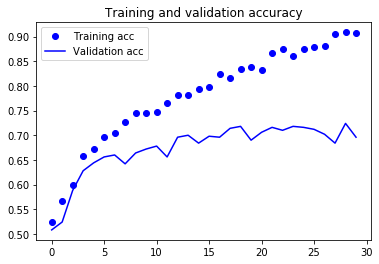

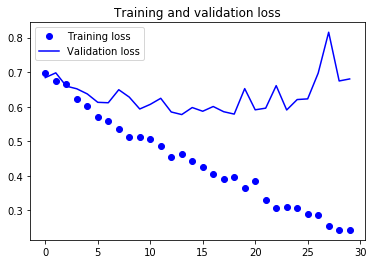

In [15]:
import matplotlib.pyplot as plt

#history = history_scratch

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



These plots are characteristic of overfitting. Our training accuracy increases until it reaches nearly 100%, while our validation accuracy stalls at 70-72%.

Because we only have relatively few training samples (2000), **overfitting** is going to be our number one concern. 

Overfitting can be mitigated using dropout and weight decay (L2 regularization). We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: **Data Augmentation.**


# 2. Baseline + Data augmentation

## 2.1. Data Augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. 

Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.


Since we only have few examples, our number one concern should be overfitting. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions.

In [16]:
# Import image data generator

datagen = ImageDataGenerator(
        rotation_range=40, #rotation_range degrees (0-180), range that randomly rotate pictures
        width_shift_range=0.2, #width_shift range (fraction of total width) within which to randomly translate pic
        height_shift_range=0.2, # -ii-
        
        #rescale value we multiply the data before any other processing. 
        #Our original images consist in RGB coefficients in the 0-255, 
        #but such values would be too high for our models to process (given typical learning rate), 
        # so we target values between 0 and 1 instead by scaling with a 1/255. factor.
        rescale=1./255,
        
        #randomly applying shearing transformations (shear mapping is a linear map that 
        #displaces each point in fixed direction, by an amount proportional to its 
        #signed distance from a line that is parallel to that direction)
        shear_range=0.2, 
        zoom_range=0.2, #randomly zooming inside pictures
        
        #is for randomly flipping half of the images horizontally 
        #--relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).

        horizontal_flip=True,
    
        #is the strategy used for filling in newly created pixels, 
        #which can appear after a rotation or a width/height shift.
        fill_mode='nearest')

Now let's start generating some pictures using this tool and save them to a temporary directory, so we can get a feel for what our augmentation strategy is doing --we disable rescaling in this case to keep the images displayable:

['cat_0_8086.jpeg', 'cat_0_2798.jpeg', 'cat_0_6000.jpeg', 'cat_0_4139.jpeg']
Image cat_0_8086.jpeg


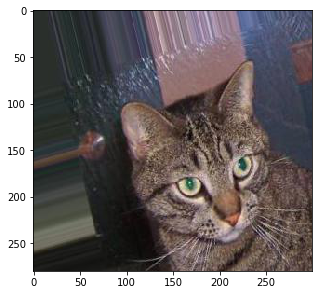

Image cat_0_2798.jpeg


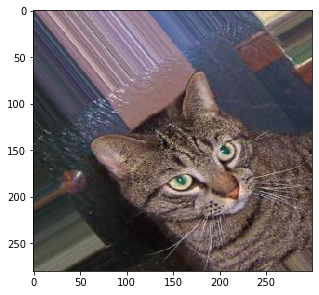

Image cat_0_6000.jpeg


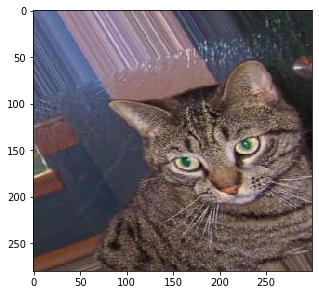

Image cat_0_4139.jpeg


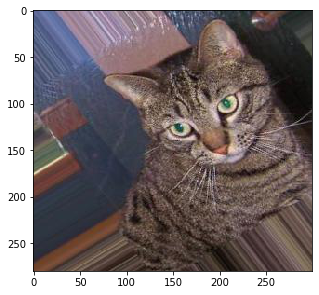

Image cat_0_9567.jpeg


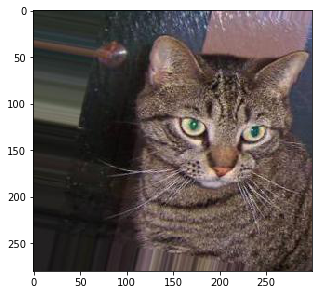

Image cat_0_1507.jpeg


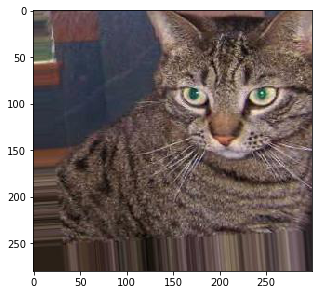

Image cat_0_366.jpeg


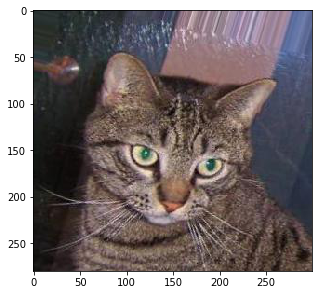

Image cat_0_8422.jpeg


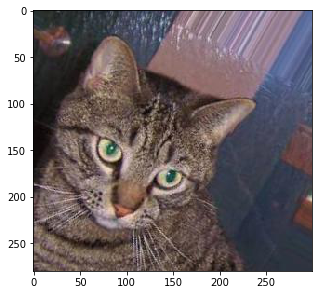

Image cat_0_9291.jpeg


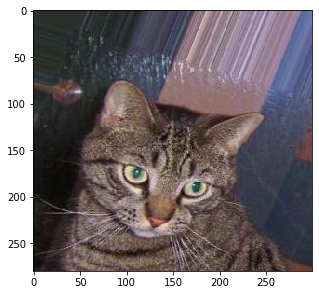

Image cat_0_805.jpeg


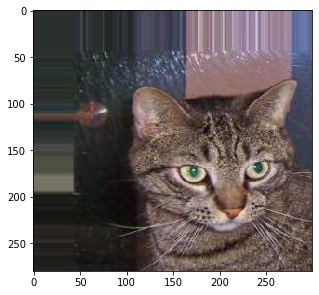

In [17]:
import cv2
img = load_img(TRAIN_DIR+'cats/cat0002.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0

from PIL import Image


if not os.path.exists('preview'):
    os.makedirs('preview')

for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

prev_files = next(os.walk('./preview'))[2]
print(prev_files[:4])

def read_image(file_path):
    # For image visualization
    im = np.array(Image.open(file_path))
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return im

def plot_pic(img):
    # Plot openCV pic
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()


for img in prev_files[:10]:
    print('Image '+img)
    plot_pic('./preview/'+img)

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        TRAIN_DIR,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## 2.2. Model

In [19]:
# model construction

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


'''
On top of it we stick two fully-connected layers. 
We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. 
To go with it we will also use the binary_crossentropy loss to train our model.
'''

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## 2.3. Training

In [20]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=2000//32,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=800//32,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 25 steps
Epoch 1/50
62/62 [==============================] - 33s 534ms/step - loss: 0.6934 - acc: 0.5056 - val_loss: 0.6873 - val_acc: 0.5000
Epoch 2/50
62/62 [==============================] - 26s 414ms/step - loss: 0.6867 - acc: 0.5320 - val_loss: 0.6716 - val_acc: 0.5850
Epoch 3/50
62/62 [==============================] - 25s 410ms/step - loss: 0.6795 - acc: 0.5686 - val_loss: 0.6627 - val_acc: 0.6125
Epoch 4/50
62/62 [==============================] - 26s 413ms/step - loss: 0.6708 - acc: 0.5940 - val_loss: 0.6615 - val_acc: 0.5800
Epoch 5/50
62/62 [==============================] - 25s 411ms/step - loss: 0.6584 - acc: 0.6113 - val_loss: 0.6381 - val_acc: 0.6288
Epoch 6/50
62/62 [==============================] - 26s 415ms/step - loss: 0.6498 - acc: 0.6184 - val_loss: 0.6227 - val_acc: 0.6388
Epoch 7/50
62/62 [==============================] - 25s 411ms/step - loss: 0.6350 - acc: 0.6372 - val_loss: 0.

### Save the model

In [21]:
model.save('cats_and_dogs_small_1.h5')

### Load the model

In [22]:
from keras.models import load_model

mod = load_model('cats_and_dogs_small_2.h5')
mod.summary()  # As a reminder.

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

## 2.4. Testing

In [23]:
model.evaluate(validation_generator,steps=validation_generator.n//32,verbose=1)[0]

  ...
    to  
  ['...']
25/25 [==============================] - 4s 156ms/step - loss: 0.4646 - acc: 0.7887


0.4646056342124939

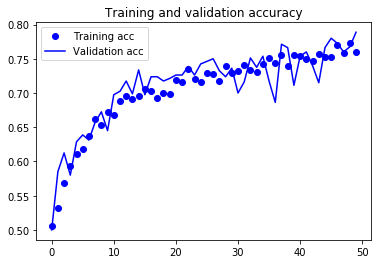

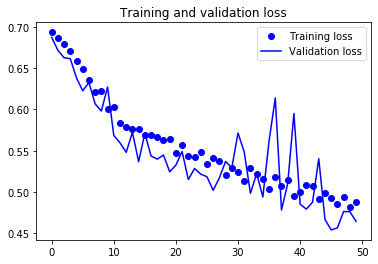

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



I think this is a DOG


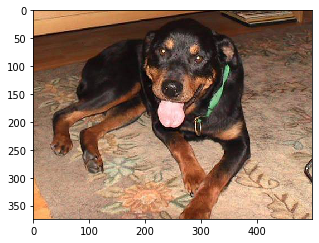



I think this is a DOG


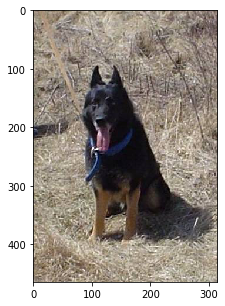



I think this is a DOG


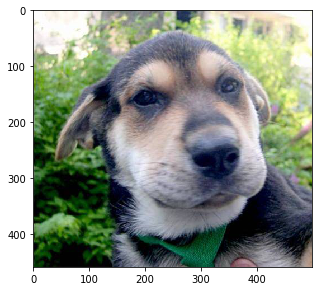



I think this is a DOG


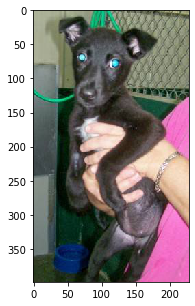



I think this is a CAT


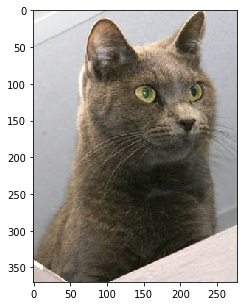



I think this is a DOG


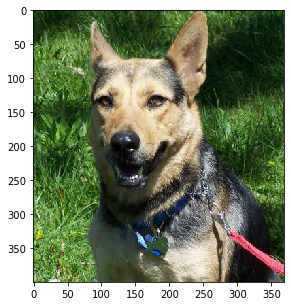



I think this is a CAT


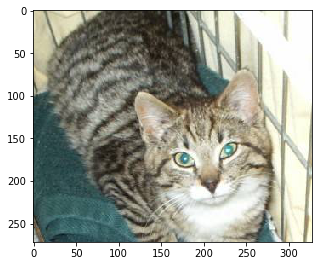



I think this is a DOG


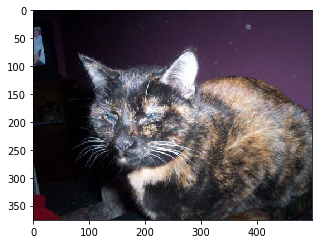



I think this is a DOG


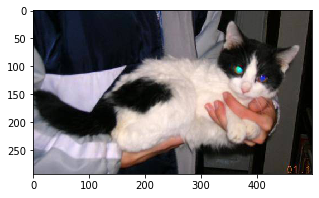



I think this is a DOG


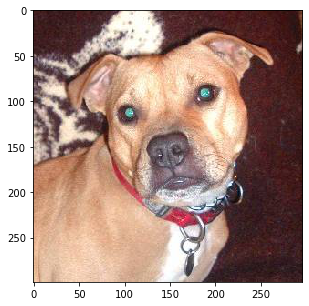

In [25]:
# Plot picture and print class prediction on cats vs dogs (unsorted)

try_images =  [TEST_DIR+'catvdog/'+img for img in os.listdir(TEST_DIR+'catvdog/')]

def predict(mod,i=0,r=None):
    if r==None:
        r=[i]
        
    for idx in r:
        if 'DS_Store' in try_images[idx]:
            continue
        
        img_path = try_images[idx]
        img = image.load_img(img_path, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        class_pred = mod.predict_classes(x,verbose=0)
        
        if class_pred == 0:
            class_guess='CAT'
        else:
            class_guess='DOG'
        
        print('\n\nI think this is a ' + class_guess)
        plot_pic(try_images[idx])

predict(mod,r=range(10))


# 3. Transfer Learning

## 3.1. Introduction

### Build a more powerful Cats vs Dogs binary classifier

Now we will use [Transfer learning](http://cs231n.github.io/transfer-learning/) and remove the top layer of a pretrained network [(VGG16 on Imagenet)](https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/), extracting the features of the training and validation images and then just training the fully connected top layer of that network. This way we will be able to make accurate predictions even though we just have a small data set.

The data conists of 2000 training images (1000 cats and 1000 dogs), 800 validation images (400 cats and 400 dogs), and 100 test images (cats and dogs mixed). [Get the data here.](https://www.dropbox.com/s/a8zo6udq83xsx05/data-x_cnn_data.tar.gz?dl=1) 

The pretrained VGG16 weighs that you should load into your model (in order to extract the bottleneck features) can be [downloaded here](https://www.dropbox.com/s/fvx7hv5vr8j3sc6/vgg16_weights_features.tar.gz?dl=1). Extracted features are included so that you can run the code instantly.


The reason why we are using a pretrained network, extracting bottleneck features and training only the top layers is that this is a great way to obtain a high prediction accuracy without having a huge data set and without having to run the training for a long time. It would require much more data and take up to several days to run this analysis and training your own CNN on a personal computer (in order to obtain the same level of accuracy).


## 3.2. Extract bottleneck features from the data set

A good explanation on how this works (rewritten from source: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

#### Using the bottleneck features of a pre-trained network: 90% accuracy in 1 min (GPU) / 10 mins (CPU)

We are leveraging the predictive power of a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

We will use the VGG16 architecture, pre-trained on the ImageNet dataset. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well. The method presented here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet.

Here's what the VGG16 architecture looks like:

![Image of Yaktocat](https://blog.keras.io/img/imgclf/vgg16_original.png)

### Horizontal visualization

![https://datatoanalytics.files.wordpress.com/2017/04/vgg161.png](https://datatoanalytics.files.wordpress.com/2017/04/vgg161.png)


### Strategy to extract bottleneck features:

We will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will pass our training, validation, and test data through this model once, recording the output (the "bottleneck features" from the VGG16 model, ie the output of the last activation maps before the fully-connected layers). 

The output will be saved as three numpy arrays, and stored on disk as `.npy` files.. The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once.

### This is how the VGG16 net looks in code
You can see the full implementation here of the network we're building and loading in: https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py


```python
    # VGG 16 model architecture
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Classification block
    model.add(Flatten(name='flatten')(x))
    model.add(Dense(4096, activation='relu', name='fc1')(x))
    model.add(Dense(4096, activation='relu', name='fc2')(x))
    model.add(Dense(classes, activation='softmax', name='predictions')(x))
```

### IMAGEnet Benchmarks (the structure we're using today, 2nd place in 2014)

![https://qph.ec.quoracdn.net/main-qimg-fbd17e02f01e60b38ff8ee864c647303](https://cdn-images-1.medium.com/max/800/1*HyaPKtxU07iVzZ4RjJJlUQ.png)

In [26]:
# Function for saving bottleneck features
# This can take ~10mins to run

#  Run model once to record the bottleneck features using image data generators:

def save_bottleneck_features():

    from tensorflow.keras import applications
    model = applications.vgg16.VGG16(include_top=False, weights='imagenet', \
                                     input_tensor=None, input_shape=(img_width, img_height,3))
    
    # documentation: https://keras.io/applications/#vgg16
    
    print('TensorFlow VGG16 model architecture loaded')
    # include_top = False, because we drop last layer, then we also only need to
    # download weight file that is small
    # input_shape with channels last for tensorflow
    
    # Our original images consist in RGB coefficients in the 0-255 interval, 
    # but such values would be too high for our models to process (given typical learning rate), 
    # so we target values between 0 and 1 instead by scaling with a 1/255. factor.
    datagen = ImageDataGenerator(rescale=1./255)
    
    def generate_features(DIR,n_samples,name_str):
        '''This is a generator that will read pictures found in
        subfolers of 'data/*', and indefinitely generate
        batches of rescaled images used to predict
        the bottleneck features of the images once
        using model.predict_generator(**args**)'''

        print('Generate '+name_str+' image features')
    
        generator = datagen.flow_from_directory(
            DIR,
            target_size=(img_width, img_height),
            batch_size=1,
            class_mode=None, # this means our generator will only yield batches of data, no labels
            shuffle=False) # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
        
        
        features = model.predict_generator(generator, n_samples,verbose=True)
        # the predict_generator method returns the output of a model, given
        # a generator that yields batches of numpy data
        
        np.save('features_'+name_str+'.npy', features) # save bottleneck features to file
    
    generate_features(TEST_DIR, n_test_samples, 'test')
    #generate_features(TRAIN_DIR, n_train_samples, 'train')
    #generate_features(VAL_DIR, n_validation_samples, 'validation')
    
    print('\nDone! Bottleneck features have been saved')


print('This has been done before the lecture! Takes 5+ mins to run.')
save_bottleneck_features()

This has been done before the lecture! Takes 5+ mins to run.
TensorFlow VGG16 model architecture loaded
Generate test image features
Found 100 images belonging to 1 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
100/100 [==============================] - 9s 88ms/step

Done! Bottleneck features have been saved


In [27]:
# Extra
# Obtain class labels and binary classification for validation data
datagen = ImageDataGenerator(rescale=1./255)
val_gen = datagen.flow_from_directory(VAL_DIR,target_size=(img_width, img_height),
                                        batch_size=32,class_mode=None,shuffle=False)

val_labels = val_gen.classes

print('\nClassifications:\n',val_gen.class_indices)
print('\nClass labels:\n',val_labels)

Found 800 images belonging to 2 classes.

Classifications:
 {'cats': 0, 'dogs': 1}

Class labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 

## 3.3. Train the top layer of your CNN

Let's load the bottle neck features and connect them to the fully connected model.


In [28]:
# Load in bottleneck features
# Run the code below to train your CNN with the training data

train_data = np.load('features_train.npy')
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * (n_train_samples // 2) + [1] * (n_train_samples // 2))

validation_data = np.load('features_validation.npy')
# same as val_labels above
validation_labels = np.array([0] * (n_validation_samples // 2) + [1] * (n_validation_samples // 2))

# Add top layers trained ontop of extracted VGG features
# Small fully connected model trained on top of the stored features
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

'''
#We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. 
#To go with it we will also use the binary_crossentropy loss to train our model.

'''
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

MODEL_WEIGHTS_FILE = 'vgg16-best-weights.h5'
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', verbose=1, save_best_only=True)]

history = model.fit(train_data, train_labels, verbose=1, \
                    epochs=20, batch_size=32, \
                    validation_data=(validation_data, validation_labels),
                    callbacks=callbacks)

# Save weights to disk

# Save model architecture to disk
model_json = model.to_json()
with open("mod_appendix.json", "w") as json_file: # save model
    json_file.write(model_json)

# Save model weights
model.save_weights("catvsdogs_VGG16_pretrained_tf_top.h5") # save weights
print("Saved model to disk")
print('Done!')

Train on 2000 samples, validate on 800 samples
Epoch 1/20
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.8425 - accuracy: 0.7240 - val_loss: 0.4702 - val_accuracy: 0.7850
Epoch 2/20
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.3784 - accuracy: 0.8295 - val_loss: 0.6407 - val_accuracy: 0.6963
Epoch 3/20
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.2874 - accuracy: 0.8795 - val_loss: 0.3099 - val_accuracy: 0.8575
Epoch 4/20
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.2775 - accuracy: 0.8835 - val_loss: 0.2324 - val_accuracy: 0.9087
Epoch 5/20
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.2115 - accuracy: 0.9075 - val_loss: 0.3083 - val_accuracy: 0.8850
Epoch 6/20
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.2093 - accuracy: 0.9130 - val_loss: 0.2517 - val_accuracy: 0.9013
Epoch 7/20
2000/2000 [==============================] - 2s 1ms/sample - loss:

### Load the best weights

In [29]:
history.model.load_weights('vgg16-best-weights.h5')

In [30]:
model = history.model

In [31]:
model.summary() # only the last layer hsa 2Mn weights.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


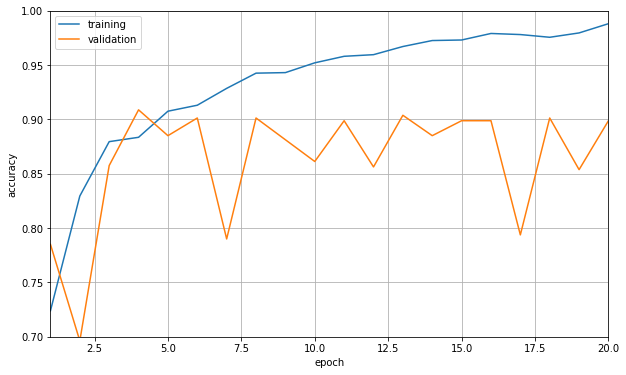

In [32]:
acc = pd.DataFrame({'epoch': range(1,n_epoch+1),
                    'training': history.history['accuracy'],
                    'validation': history.history['val_accuracy']})
ax = acc.plot(x='epoch', figsize=(10,6), grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.7,1.0]);

## 3.4. Testing

1. Testing on validation data
2. Testing on unlabeled test data


In [33]:
# Alternative
print('Model accuracy on validation set:',model.evaluate(validation_data,val_labels,verbose=0)[1]*100,'%')

Model accuracy on validation set: 90.75000286102295 %


In [34]:
## Print try images:

# Use the model trained in Problem 1 to classify the test data images.
# Create a function that loads one image from the test data and then predicts
# if it is a cat or a dog and with what probability it thinks it is a cat or a dog
#
# Use variable test_data to make predictions
# Use list test_images to obtain the file name for all images (Note: test_images[0] corresponds to test_data[0])
# Use function plot_pic(img) to plot the image file

## Load in processed images feature to feed into bottleneck model

from PIL import Image

test_data = np.load('features_test.npy')

test_images =  [TEST_DIR+'catvdog/'+img for img in sorted(os.listdir(TEST_DIR+'catvdog/'))]

def read_image(file_path):
    # For image visualization
    im = np.array(Image.open(file_path))
    return im

def plot_pic(img):
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()



I think this is a CAT with 0.99928 probability


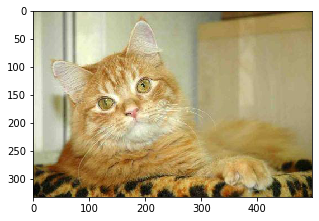



I think this is a CAT with 0.99995 probability


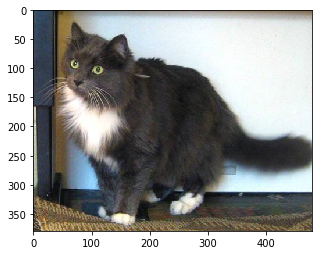



I think this is a DOG with 0.5381 probability


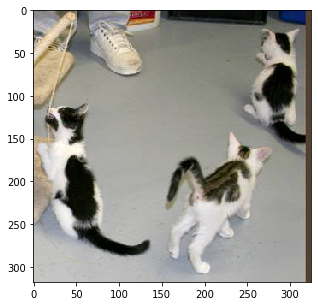



I think this is a CAT with 0.83257 probability


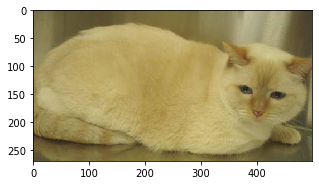



I think this is a CAT with 0.99982 probability


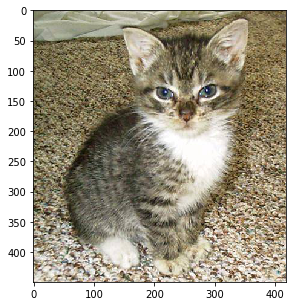



I think this is a CAT with 1.0 probability


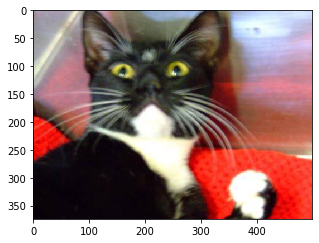



I think this is a DOG with 0.99969 probability


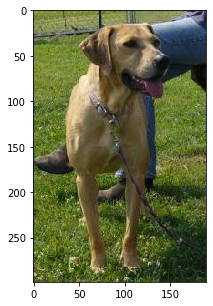



I think this is a DOG with 0.94999 probability


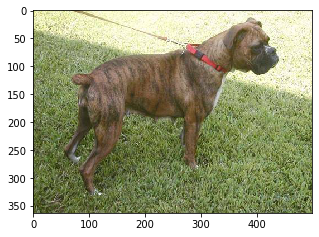



I think this is a CAT with 0.99956 probability


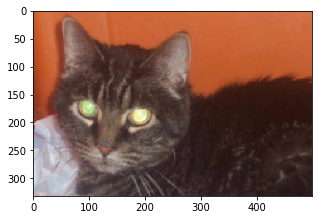



I think this is a DOG with 0.99767 probability


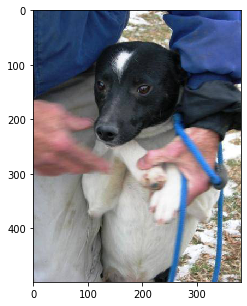



I think this is a CAT with 0.93719 probability


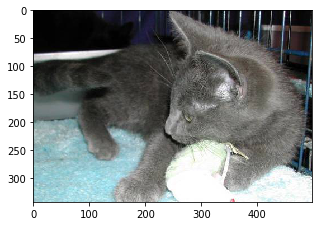



I think this is a DOG with 0.95588 probability


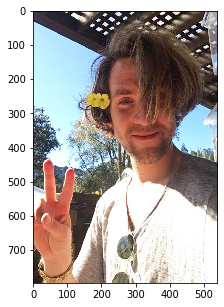

In [35]:
def predict(mod,i=0,r=None):
    if r==None:
        r=[i]
        
    for idx in r:
        class_pred = mod.predict_classes(test_data,verbose=0)[idx]
        prob_pred = mod.predict_proba(test_data,verbose=0)[idx]
        
        if class_pred ==0:
            prob_pred = 1-prob_pred
            class_guess='CAT'
        else:
            class_guess='DOG'
        
        print('\n\nI think this is a ' + class_guess + ' with ' +str(round(float(prob_pred),5)) + ' probability')
        if test_images[idx]=='./data/test/catvdog/.DS_Store' or '.ipynb_checkpoints' in test_images[idx]:
            continue
        plot_pic(test_images[idx])

#predict(model,r=range(0,10))       
predict(model,r=range(88,len(test_images))) # seems to be doing really well

# 4. Visualizing CNN learning
Intermediate activations

In [36]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [37]:
img_path = TRAIN_DIR+'cats/cat0003.jpg'

In [38]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


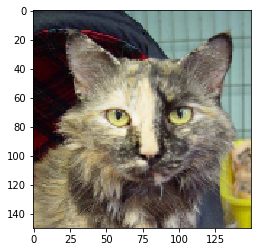

In [39]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [40]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [41]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [42]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


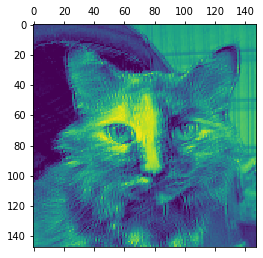

In [43]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

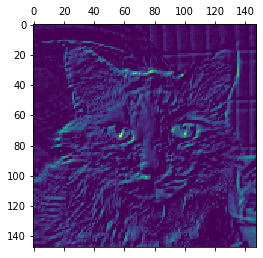

In [44]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

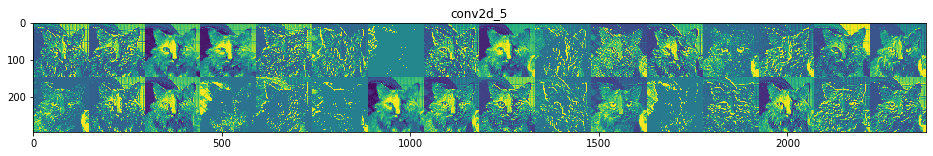

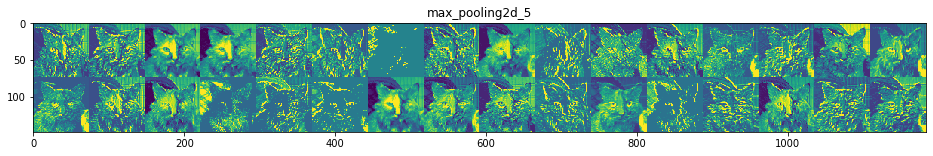

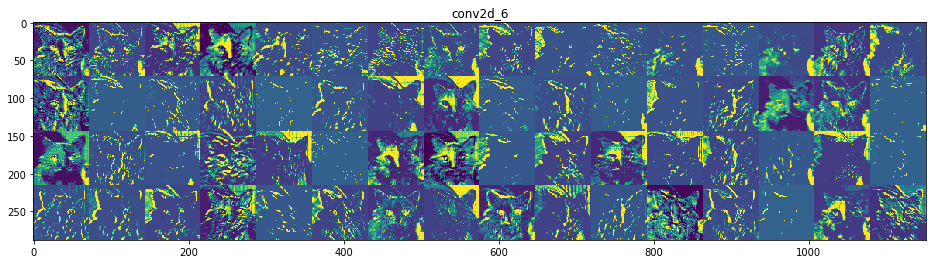

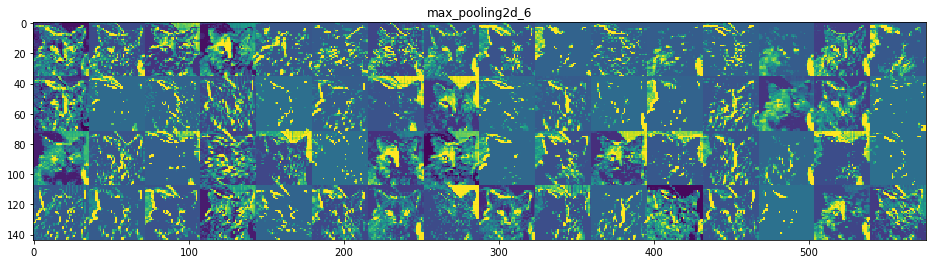

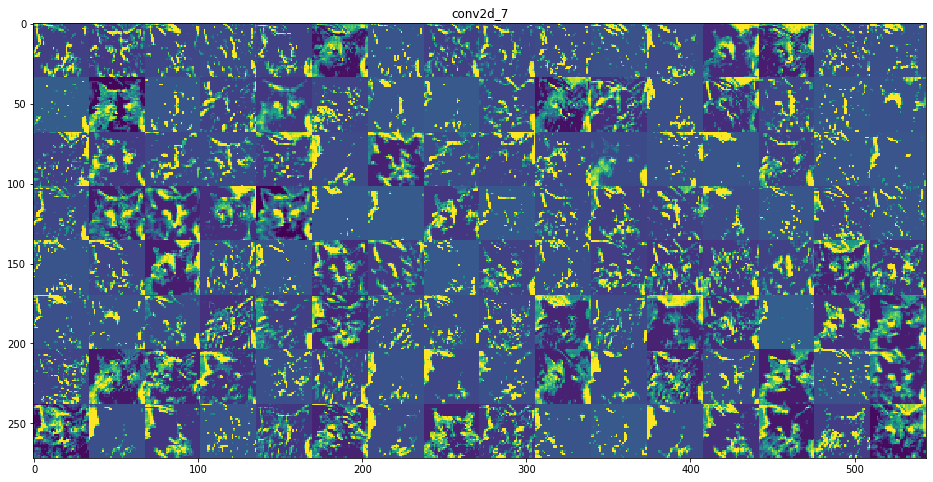

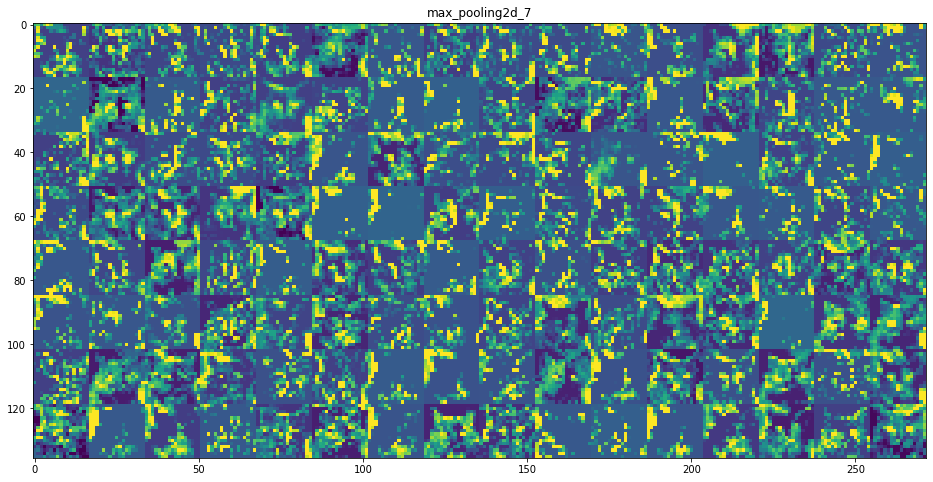

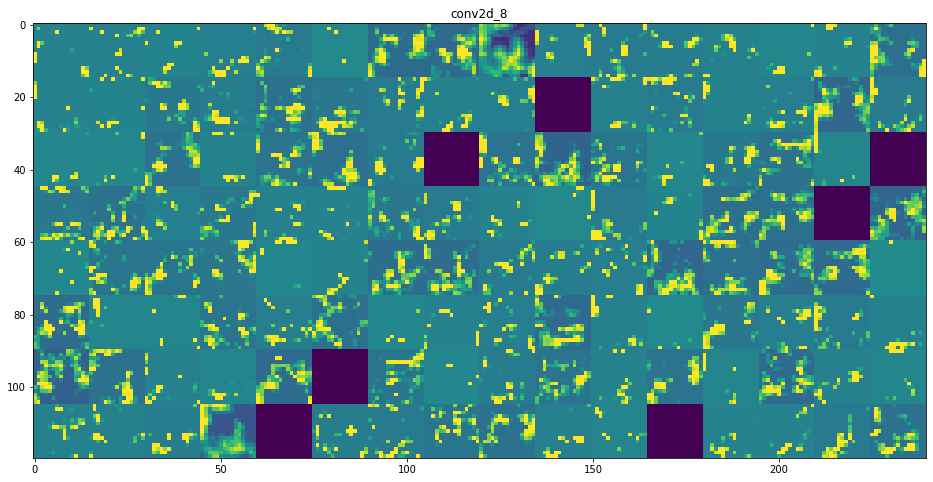

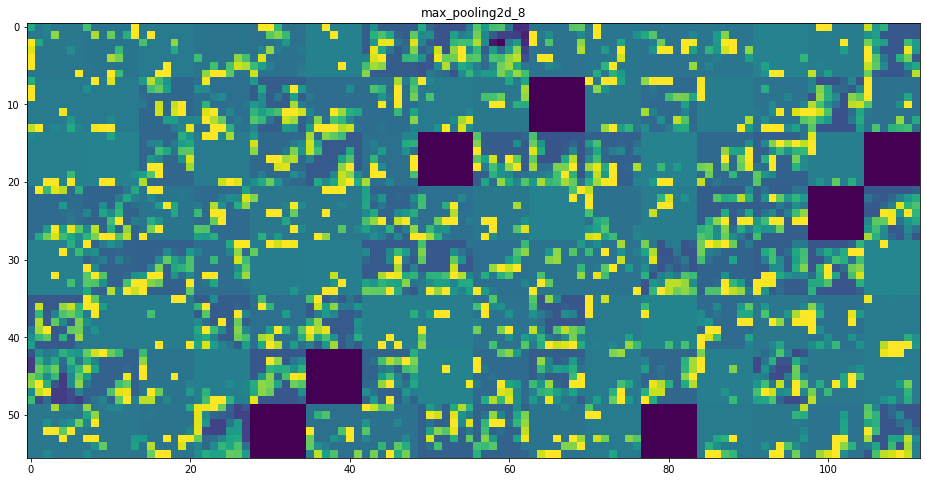

In [45]:
# from Deep Learning with Python by François Chollet
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')